In [1]:
import sys
from pathlib import Path

# Add src directory to Python path
project_root = Path.cwd().parent  
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))
    print(f"Added {src_path} to Python path")


Added /Users/cooper/Desktop/hydro-forecasting/src to Python path


In [2]:
from typing import Optional
import matplotlib.pyplot as plt
import seaborn as sns


from hydro_forecasting.data.in_memory_datamodule import HydroInMemoryDataModule 
from hydro_forecasting.preprocessing.grouped import GroupedPipeline
from sklearn.pipeline import Pipeline
from hydro_forecasting.preprocessing.standard_scale import StandardScaleTransformer
from hydro_forecasting.preprocessing.normalize import NormalizeTransformer
from hydro_forecasting.data.caravanify_parquet import (
    CaravanifyParquet,
    CaravanifyParquetConfig,
)

from hydro_forecasting.models.tide import LitTiDE, TiDEConfig
from hydro_forecasting.model_evaluation.hp_from_yaml import hp_from_yaml

from hydro_forecasting.model_evaluation.evaluators import TSForecastEvaluator

import polars as pl

---

In [3]:
FORCING_FEATURES = [
    "snow_depth_water_equivalent_mean",
    "surface_net_solar_radiation_mean",
    "surface_net_thermal_radiation_mean",
    "potential_evaporation_sum_ERA5_LAND",
    "potential_evaporation_sum_FAO_PENMAN_MONTEITH",
    "temperature_2m_mean",
    "temperature_2m_min",
    "temperature_2m_max",
    "total_precipitation_sum",
]
STATIC_FEATURES = [
    "p_mean",
    "area",
    "ele_mt_sav",
    "high_prec_dur",
    "frac_snow",
    "high_prec_freq",
    "slp_dg_sav",
    "cly_pc_sav",
    "aridity_ERA5_LAND",
    "aridity_FAO_PM",
]

TARGET = "streamflow"

DATA_CHUNK_SIZE = 100

In [4]:
yaml_path = Path("/Users/cooper/Desktop/hydro-forecasting/notebooks/tide.yaml")

tide_hp = hp_from_yaml("tide", yaml_path)

In [5]:
tide_hp

{'decoder_output_size': 24,
 'dropout': 0.4040330172235821,
 'future_forcing_projection_size': 0,
 'future_input_size': 9,
 'group_identifier': 'gauge_id',
 'hidden_size': 110,
 'input_len': 34,
 'input_size': 10,
 'learning_rate': 0.00029399848560567596,
 'num_decoder_layers': 2,
 'num_encoder_layers': 2,
 'output_len': 10,
 'past_feature_projection_size': 0,
 'scheduler_factor': 0.5,
 'scheduler_patience': 5,
 'static_size': 10,
 'temporal_decoder_hidden_size': 51,
 'use_layer_norm': False}

In [6]:
TiDE_config = TiDEConfig(**tide_hp)

---

In [7]:
config_ca = CaravanifyParquetConfig(
    attributes_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/attributes",
    timeseries_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/timeseries/csv",
    shapefile_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CA/post_processed/shapefiles",
    gauge_id_prefix="CA",
    use_hydroatlas_attributes=True,
    use_caravan_attributes=True,
    use_other_attributes=True,
)

caravan_ca = CaravanifyParquet(config_ca)
basin_ids = caravan_ca.get_all_gauge_ids()


caravan_ca.load_stations(basin_ids)

# Prepare data frames
ts_columns = FORCING_FEATURES + [TARGET]
static_columns = STATIC_FEATURES

ca_ts_data = caravan_ca.get_time_series()[ts_columns + ["date"] + ["gauge_id"]]
ca_static_data = caravan_ca.get_static_attributes()[static_columns + ["country", "gauge_id"]]

In [8]:
# ids for the COUUNTRY
COUNTRY = "Kyrgyzstan"

country_ids = ca_static_data[ca_static_data["country"] == COUNTRY]["gauge_id"].unique()

ca_ts_data = ca_ts_data[ca_ts_data["gauge_id"].isin(country_ids)]
ca_static_data = ca_static_data[ca_static_data["gauge_id"].isin(country_ids)]

print(f"Found {len(country_ids)} total CA basins in {COUNTRY}")

Found 62 total CA basins in Kyrgyzstan


---

In [9]:
feature_pipeline = GroupedPipeline(
    Pipeline([("scaler", StandardScaleTransformer()), ("normalizer", NormalizeTransformer())]),
    columns=FORCING_FEATURES,
    group_identifier="gauge_id",
)

target_pipeline = GroupedPipeline(
    Pipeline([("scaler", StandardScaleTransformer()), ("normalizer", NormalizeTransformer())]),
    columns=["streamflow"],
    group_identifier="gauge_id",
)

static_pipeline = Pipeline([("scaler", StandardScaleTransformer())])

preprocessing_config = {
    "features": {"pipeline": feature_pipeline},
    "target": {"pipeline": target_pipeline},
    "static_features": {"pipeline": static_pipeline, "columns": STATIC_FEATURES},
}

In [10]:
region_time_series_base_dirs = {
    "CA": "/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/timeseries/csv/CA",
}

region_static_attributes_base_dirs = {
    "CA": "/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/attributes/CA",
}

datamodule = HydroInMemoryDataModule(
    region_time_series_base_dirs=region_time_series_base_dirs,
    region_static_attributes_base_dirs=region_static_attributes_base_dirs,
    path_to_preprocessing_output_directory="/Users/cooper/Desktop/hydro-forecasting/tests/first_big_test",
    group_identifier="gauge_id",
    batch_size=2048,
    input_length=tide_hp["input_len"],
    output_length=tide_hp["output_len"],
    forcing_features=FORCING_FEATURES,
    static_features=STATIC_FEATURES,
    target=TARGET,
    preprocessing_configs=preprocessing_config,
    num_workers=4,
    min_train_years=1,
    train_prop=0.5,
    val_prop=0.1,
    test_prop=0.4,
    max_imputation_gap_size=5,
    list_of_gauge_ids_to_process=basin_ids,
    is_autoregressive=True,
    chunk_size=DATA_CHUNK_SIZE,
)

datamodule.prepare_data()
datamodule.setup()

INFO:hydro_forecasting.data.in_memory_datamodule:Starting data preparation...
INFO:hydro_forecasting.data.in_memory_datamodule:Generated Run UUID for current config: 49de962e-8aa5-5330-9a1d-d710c519668b
INFO:hydro_forecasting.data.in_memory_datamodule:Checking for existing processed data at: /Users/cooper/Desktop/hydro-forecasting/tests/first_big_test/49de962e-8aa5-5330-9a1d-d710c519668b
INFO:hydro_forecasting.data.in_memory_datamodule:Successfully validated and prepared to reuse data from /Users/cooper/Desktop/hydro-forecasting/tests/first_big_test/49de962e-8aa5-5330-9a1d-d710c519668b
INFO:hydro_forecasting.data.in_memory_datamodule:Reusing existing processed data from run_uuid: 49de962e-8aa5-5330-9a1d-d710c519668b
INFO:hydro_forecasting.data.in_memory_datamodule:Loaded 3 pipelines and data for 78 basins from reused run.
INFO:hydro_forecasting.data.in_memory_datamodule:Found 78 basins for synchronized train/val chunking.
INFO:hydro_forecasting.data.in_memory_datamodule:Found 78 basins

In [11]:
tide_benchmark_ckpt = "/Users/cooper/Desktop/hydro-forecasting/experiments/TiDE_on_low_medium/output/checkpoints/last.ckpt"

tide_model = LitTiDE.load_from_checkpoint(
    tide_benchmark_ckpt, config=TiDE_config
)



# Create a dictionary mapping model names to (model, datamodule) tuples
models_and_datamodules = {
    "TiDE": (tide_model, datamodule),

}


evaluator = TSForecastEvaluator(
    horizons=list(range(1, 11)),
    models_and_datamodules=models_and_datamodules,
    trainer_kwargs={"accelerator": "cpu", "devices": 1},
)

In [12]:
# Run evaluation
results = evaluator.test_models()

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:hydro_forecasting.data.in_memory_datamodule:Data preparation has already run.


Testing TiDE...


INFO:hydro_forecasting.data.in_memory_datamodule:Loading test data for 78 basins...
INFO:hydro_forecasting.data.in_memory_datamodule:Stage 'test' chunk data loaded. Shape: (199338, 12). Est. Mem: 9.13 MB
/Users/cooper/Desktop/hydro-forecasting/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Testing DataLoader 0: 100%|██████████| 96/96 [00:02<00:00, 40.44it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.12294550985097885
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [13]:
import polars as pl
from typing import Any


def filter_growing_season_polars(eval_results: dict[str, Any]) -> dict[str, Any]:
    """
    Filter evaluation results to include only data from the growing season (April to October), using Polars.

    Args:
        eval_results: dictionary containing evaluation results with a 'df' key,
                      where 'df' is a Polars DataFrame.

    Returns:
        dictionary with filtered Polars DataFrame and original metrics.
    """
    # Create a copy of the results to avoid modifying the original
    filtered_results = eval_results.copy()

    # Extract the Polars DataFrame
    # Use clone() for a deep copy in Polars
    df = eval_results["df"].clone()

    # Ensure 'date' column exists
    if "date" not in df.columns:
        raise ValueError("DataFrame must contain a 'date' column.")

    # Filter for growing season (April to October) using Polars expressions
    # Month numbers are 1 (January) to 12 (December)
    # Polars dt.month() returns month number
    growing_season_df = df.filter(
        (pl.col("date").dt.month() >= 4)
        & (pl.col("date").dt.month() <= 9)  # Corrected to month < 10 (i.e. <=9 for April to September)
        # If October is inclusive, it should be <= 10
    )
    # If your original code meant df["date"].dt.month < 10 (i.e., up to and including September),
    # then the condition should be (pl.col("date").dt.month() >= 4) & (pl.col("date").dt.month() < 10)
    # I will use the original logic: April to September (month < 10)

    growing_season_df = df.filter((pl.col("date").dt.month() >= 4) & (pl.col("date").dt.month() < 10))

    # Replace the dataframe in the results
    filtered_results["df"] = growing_season_df

    return filtered_results


def process_seasonal_results_polars(
    results: dict[str, Any],
    evaluator: Any,  # Replace Any with the actual type of TSForecastEvaluator if available
    model_keys: list[str] = None,
) -> dict[str, Any]:
    """
    Process specified model results to get seasonal metrics using Polars DataFrames.

    Args:
        results: dictionary containing results for all models.
        evaluator: Evaluator object with _calculate_overall_metrics and
                   _calculate_basin_metrics methods that can handle Polars DataFrames.
                   (As per evaluators.py, these methods already use Polars)
        model_keys: list of model keys to process. If None, process all keys in results.

    Returns:
        dictionary with seasonal results for the specified models.
    """
    seasonal_results = {}

    # If model_keys is not provided, use all keys in results
    if model_keys is None:
        model_keys = list(results.keys())  # Use list() for iteration if modifying dict

    # Process each model
    for key in model_keys:
        # Skip if the key doesn't exist in results
        if key not in results:
            print(f"Warning: Model key '{key}' not found in results. Skipping.")
            continue

        # Filter for growing season using the Polars version
        seasonal_model_results = filter_growing_season_polars(results[key])

        # Calculate metrics
        # Assuming _calculate_overall_metrics and _calculate_basin_metrics from
        # TSForecastEvaluator already accept Polars DataFrames
        seasonal_model_results["metrics"] = evaluator._calculate_overall_metrics(seasonal_model_results["df"])
        seasonal_model_results["basin_metrics"] = evaluator._calculate_basin_metrics(seasonal_model_results["df"])

        # Store in results dictionary
        seasonal_results[key] = seasonal_model_results

    return seasonal_results


seasonal_results = process_seasonal_results_polars(results, evaluator, model_keys=["TiDE"])

In [30]:
df = results["TiDE"]["df"]

df = df.filter(
    ~pl.col("prediction").is_null() & 
    ~pl.col("prediction").is_nan()
)

df

horizon,prediction,observed,basin_id,date
i32,f32,f32,str,datetime[μs]
1,0.914055,0.6,"""CA_15013""",2014-03-28 00:00:00
2,0.941474,0.6,"""CA_15013""",2014-03-29 00:00:00
3,1.064199,0.67,"""CA_15013""",2014-03-30 00:00:00
4,0.961026,0.8,"""CA_15013""",2014-03-31 00:00:00
5,0.987981,0.99,"""CA_15013""",2014-04-01 00:00:00
…,…,…,…,…
6,0.525883,0.5,"""CA_17462""",2023-01-01 00:00:00
7,0.544142,0.5,"""CA_17462""",2023-01-02 00:00:00
8,0.52171,0.5,"""CA_17462""",2023-01-03 00:00:00


In [40]:
def filter_by_horizon(df: pl.DataFrame , horizon_value: int) -> pl.DataFrame:
    # Filter the DataFrame where horizon equals the specified value
    filtered_df = df.filter(pl.col("horizon") == horizon_value)
    
    return filtered_df

df1 = filter_by_horizon(df, 5)

In [41]:
NSE = evaluator.calculate_nse(df1["prediction"].to_numpy(), df1["observed"].to_numpy())
NSE

np.float32(-53.134224)

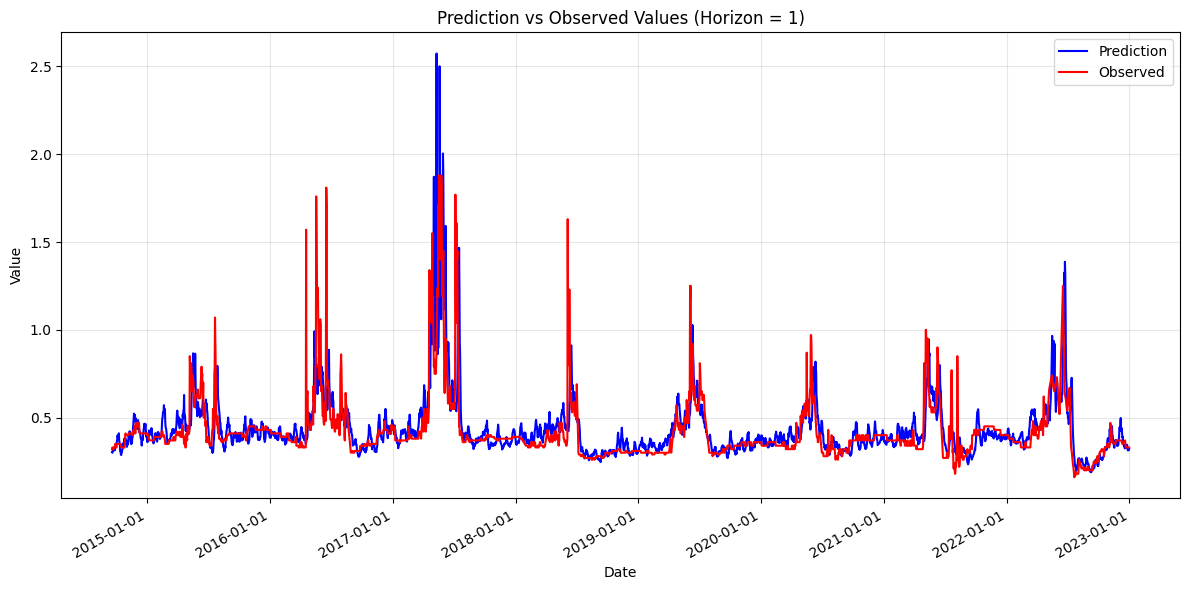

In [51]:
import matplotlib.dates as mdates

pdf = df1.filter(pl.col("basin_id") == basin_ids[54]).sort("date").to_pandas()

# Create the plot
plt.figure(figsize=(12, 6))

# Plot both prediction and observed
plt.plot(pdf['date'], pdf['prediction'], label='Prediction', color='blue')
plt.plot(pdf['date'], pdf['observed'], label='Observed', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Prediction vs Observed Values (Horizon = 1)')
plt.legend()

# Format x-axis date labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()